In [ ]:
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import tensorflow as tf

# **Load the data of one subject for training and all the others for testing**

*   The data used in this examples was first preprocessed separately in Matlab using FieldTrip toolbox.
*   The correct input shape for tensorflow backend is **(sample_number,sample_size,channel_number)**.
*   Example below uses Subject #10 for training and all remaining subjects for testing.
*   Standarization and Normalization were **not used** in this example.

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S10_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X = Samples['Xtrain']
Y = Labels['Y10']

In [ ]:
X = X.swapaxes(0, 2)
Y = Y.swapaxes(0,1)
print(X.shape)
print(Y.shape)

(248, 376, 28)
(248, 1)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

In [ ]:
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(198, 376, 28)
(50, 376, 28)
(198, 1)
(50, 1)


In [ ]:
X_train = X_train.reshape(X_train.shape[0], 376, 28).astype('float64')
X_test = X_test.reshape(X_test.shape[0], 376, 28).astype('float64')

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
Xtrain = scaler.fit_transform(X_train.reshape(-1, X_train.shape[-1])).reshape(X_train.shape)
print(Xtrain)
Xtest = scaler.fit_transform(X_test.reshape(-1, X_test.shape[-1])).reshape(X_test.shape)

In [ ]:
from sklearn.preprocessing import Normalizer
print(Xtrain)
scaler = Normalizer(norm='l1', copy=False)
x_train = scaler.fit_transform(Xtrain.reshape(Xtrain.shape[0], -1)).reshape(Xtrain.shape)
x_test = scaler.transform(Xtest.reshape(Xtest.shape[0], -1)).reshape(Xtest.shape)

In [ ]:

print(x_train)

In [ ]:
num_classes = len(np.unique(Y_train))

In [ ]:
print(num_classes)

2


# **Create a CNN model**

The designed model for this classification was as follows:


*   A 1D convolutional layer with kernel size of 3 yielding 64 filters.
*   A Batch Normalization layer.
*   A ReLu layer.
*   A dropout layer.

This layering order was repeated three times. After this a global average pooling layer gets the average for the channels of each trial. Finally a dense layer acting as a fully connected layer was placed in the CNN architecture with a sigmoig activation function.

For this test, the CNN model was trained using the data from one of the subjects and tested with all of the other remaining 11 subjects.

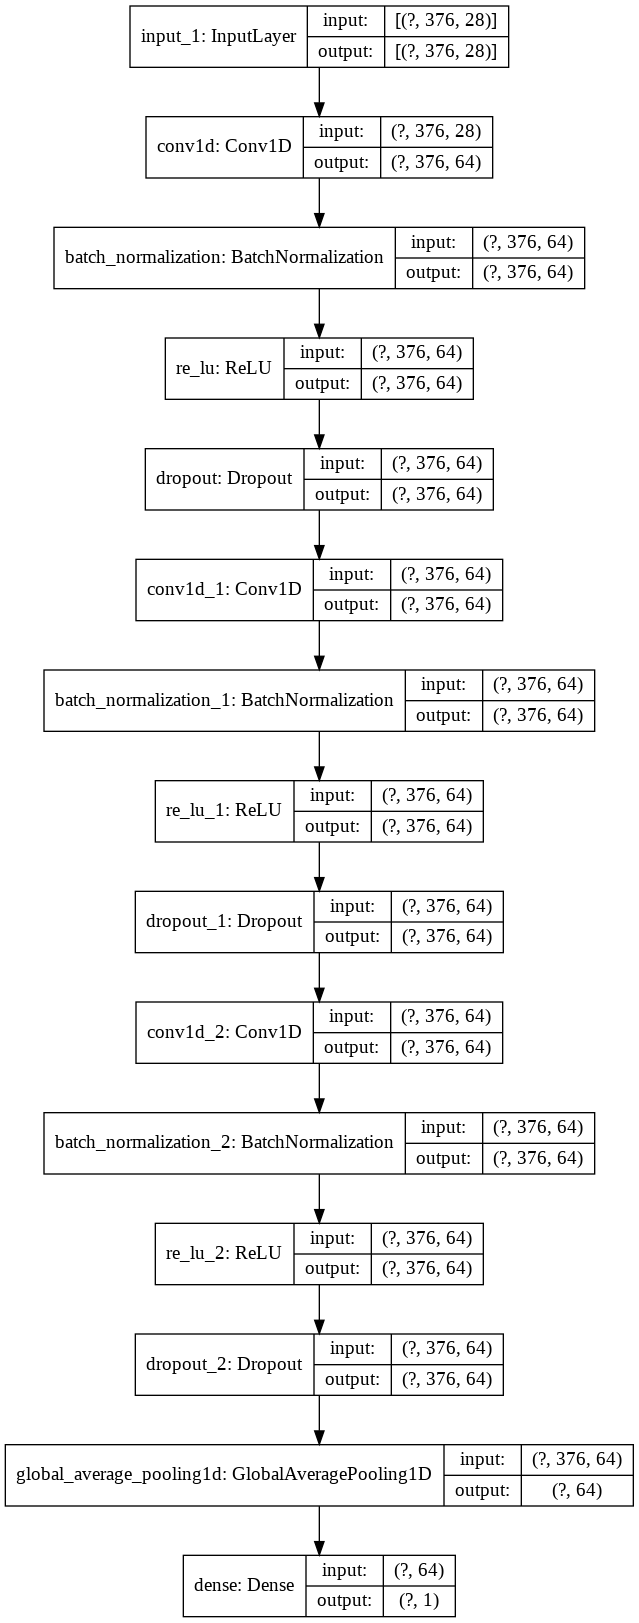

In [ ]:
input_shape =(376,28)
def make_model(input_shape):
    input_layer = keras.layers.Input(input_shape)

    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)
    conv1 = keras.layers.Dropout(.2)(conv1)

    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    conv2 = keras.layers.Dropout(.2)(conv2)

    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)
    conv3 = keras.layers.Dropout(.2)(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(1, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
keras.utils.plot_model(model, show_shapes=True)

In [ ]:
epochs = 500
batch_size = 2

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "Subject10_Model.h5", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    #loss = "sparse_categorical_crossentropy",
    loss="binary_crossentropy",
    metrics=["accuracy",keras.metrics.TruePositives(name='tp'),
           keras.metrics.FalsePositives(name='fp'),
           keras.metrics.TrueNegatives(name='tn'),
           keras.metrics.FalseNegatives(name='fn')]
)
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

Epoch 1/500
79/79 [==============================] - 2s 20ms/step - loss: 0.4855 - accuracy: 0.7215 - tp: 53.0000 - fp: 17.0000 - tn: 61.0000 - fn: 27.0000 - val_loss: 0.2946 - val_accuracy: 0.9250 - val_tp: 20.0000 - val_fp: 3.0000 - val_tn: 17.0000 - val_fn: 0.0000e+00
Epoch 2/500
79/79 [==============================] - 1s 12ms/step - loss: 0.4398 - accuracy: 0.7658 - tp: 65.0000 - fp: 22.0000 - tn: 56.0000 - fn: 15.0000 - val_loss: 0.2687 - val_accuracy: 0.9750 - val_tp: 20.0000 - val_fp: 1.0000 - val_tn: 19.0000 - val_fn: 0.0000e+00
Epoch 3/500
79/79 [==============================] - 1s 13ms/step - loss: 0.4159 - accuracy: 0.8228 - tp: 68.0000 - fp: 16.0000 - tn: 62.0000 - fn: 12.0000 - val_loss: 0.2335 - val_accuracy: 0.9750 - val_tp: 20.0000 - val_fp: 1.0000 - val_tn: 19.0000 - val_fn: 0.0000e+00
Epoch 4/500
79/79 [==============================] - 1s 12ms/step - loss: 0.3153 - accuracy: 0.9114 - tp: 73.0000 - fp: 7.0000 - tn: 71.0000 - fn: 7.0000 - val_loss: 0.1798 - val_accur

In [ ]:
for i in range(len(Y_test)):
	print("X=%s, Predicted=%s" % (Y_test[i], y_pred[i]))


In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X_test, Y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

2/2 [==============================] - 0s 9ms/step - loss: 0.0092 - accuracy: 1.0000 - tp: 24.0000 - fp: 0.0000e+00 - tn: 26.0000 - fn: 0.0000e+00
Test accuracy 1.0
Test loss 0.009215287864208221
FP 24.0
TP 0.0
TN 26.0
FN 0.0


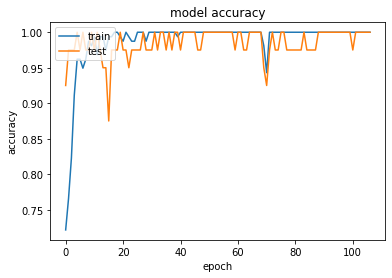

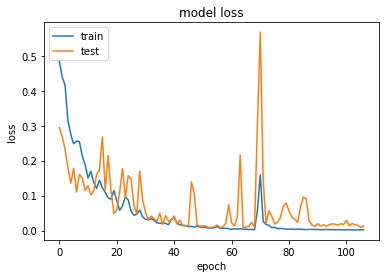

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Subject 1

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S1_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X1 = Samples['Xtrain']
Y1 = Labels['Y1']

In [ ]:
X1 = X1.swapaxes(0, 2)
Y1 = Y1.swapaxes(0,1)
print(X1.shape)
print(Y1.shape)

(252, 376, 28)
(252, 1)


In [ ]:
idx = np.random.permutation(len(X1))
X1 = X1[idx]
Y1 = Y1[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X1, Y1)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("TP",tp)
print("FP",fp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 19ms/step - loss: 2.2387 - accuracy: 0.5119 - tp: 11.0000 - fp: 8.0000 - tn: 118.0000 - fn: 115.0000
Test accuracy 0.511904776096344
Test loss 2.2386996746063232
TP 8.0
FP 11.0
TN 118.0
FN 115.0


## Subject 2

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S2_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X2 = Samples['Xtrain']
Y2 = Labels['Y2']

In [ ]:
X2 = X2.swapaxes(0, 2)
Y2 = Y2.swapaxes(0,1)
print(X2.shape)
print(Y2.shape)

(204, 376, 28)
(204, 1)


In [ ]:
idx = np.random.permutation(len(X2))
X2 = X2[idx]
Y2 = Y2[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X2, Y2)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

7/7 [==============================] - 0s 18ms/step - loss: 1.8194 - accuracy: 0.4951 - tp: 5.0000 - fp: 6.0000 - tn: 96.0000 - fn: 97.0000
Test accuracy 0.4950980246067047
Test loss 1.8194352388381958
FP 5.0
TP 6.0
TN 96.0
FN 97.0


## Subject 3

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S3_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X3 = Samples['Xtrain']
Y3 = Labels['Y3']

In [ ]:
X3 = X3.swapaxes(0, 2)
Y3 = Y3.swapaxes(0,1)
print(X3.shape)
print(Y3.shape)

(208, 376, 28)
(208, 1)


In [ ]:
idx = np.random.permutation(len(X3))
X3 = X3[idx]
Y3 = Y3[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X3, Y3)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

7/7 [==============================] - 0s 18ms/step - loss: 1.5920 - accuracy: 0.4904 - tp: 0.0000e+00 - fp: 2.0000 - tn: 102.0000 - fn: 104.0000
Test accuracy 0.49038460850715637
Test loss 1.5920472145080566
FP 0.0
TP 2.0
TN 102.0
FN 104.0


## Subject 4

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S4_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X4 = Samples['Xtrain']
Y4 = Labels['Y4']

In [ ]:
X4 = X4.swapaxes(0, 2)
Y4 = Y4.swapaxes(0,1)
print(X4.shape)
print(Y4.shape)

(226, 376, 28)
(226, 1)


In [ ]:
idx = np.random.permutation(len(X4))
X4 = X4[idx]
Y4 = Y4[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X4, Y4)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 18ms/step - loss: 1.5878 - accuracy: 0.5088 - tp: 2.0000 - fp: 0.0000e+00 - tn: 113.0000 - fn: 111.0000
Test accuracy 0.508849561214447
Test loss 1.5878417491912842
FP 2.0
TP 0.0
TN 113.0
FN 111.0


## Subject 5

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S5_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X5 = Samples['Xtrain']
Y5 = Labels['Y5']

In [ ]:
X5 = X5.swapaxes(0, 2)
Y5 = Y5.swapaxes(0,1)
print(X5.shape)
print(Y5.shape)

(224, 376, 28)
(224, 1)


In [ ]:
idx = np.random.permutation(len(X5))
X5 = X5[idx]
Y5 = Y5[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X5, Y5)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

7/7 [==============================] - 0s 21ms/step - loss: 1.6608 - accuracy: 0.6696 - tp: 47.0000 - fp: 9.0000 - tn: 103.0000 - fn: 65.0000
Test accuracy 0.6696428656578064
Test loss 1.6607882976531982
FP 47.0
TP 9.0
TN 103.0
FN 65.0


## Subject 6

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S6_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X6 = Samples['Xtrain']
Y6 = Labels['Y6']

In [ ]:
X6 = X6.swapaxes(0, 2)
Y6 = Y6.swapaxes(0,1)
print(X6.shape)
print(Y6.shape)

(234, 376, 28)
(234, 1)


In [ ]:
idx = np.random.permutation(len(X6))
X6 = X6[idx]
Y6 = Y6[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X6, Y6)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 19ms/step - loss: 1.2045 - accuracy: 0.5171 - tp: 12.0000 - fp: 8.0000 - tn: 109.0000 - fn: 105.0000
Test accuracy 0.5170940160751343
Test loss 1.204502820968628
FP 12.0
TP 8.0
TN 109.0
FN 105.0


## Subject 7

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S7_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X7 = Samples['Xtrain']
Y7 = Labels['Y7']

In [ ]:
X7 = X7.swapaxes(0, 2)
Y7 = Y7.swapaxes(0,1)
print(X7.shape)
print(Y7.shape)

(248, 376, 28)
(248, 1)


In [ ]:
idx = np.random.permutation(len(X7))
X7 = X7[idx]
Y7 = Y7[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X7, Y7)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 19ms/step - loss: 1.3348 - accuracy: 0.5000 - tp: 6.0000 - fp: 6.0000 - tn: 118.0000 - fn: 118.0000
Test accuracy 0.5
Test loss 1.3347899913787842
FP 6.0
TP 6.0
TN 118.0
FN 118.0


## Subject 8

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S8_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X8 = Samples['Xtrain']
Y8 = Labels['Y8']

In [ ]:
X8 = X8.swapaxes(0, 2)
Y8 = Y8.swapaxes(0,1)
print(X8.shape)
print(Y8.shape)

(242, 376, 28)
(242, 1)


In [ ]:
idx = np.random.permutation(len(X8))
X8 = X8[idx]
Y8 = Y8[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X8, Y8)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 20ms/step - loss: 1.5137 - accuracy: 0.5165 - tp: 30.0000 - fp: 26.0000 - tn: 95.0000 - fn: 91.0000
Test accuracy 0.5165289044380188
Test loss 1.5137457847595215
FP 30.0
TP 26.0
TN 95.0
FN 91.0


## Subject 9

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S9_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X9 = Samples['Xtrain']
Y9 = Labels['Y9']

In [ ]:
X9 = X9.swapaxes(0, 2)
Y9 = Y9.swapaxes(0,1)
print(X9.shape)
print(Y9.shape)

(266, 376, 28)
(266, 1)


In [ ]:
idx = np.random.permutation(len(X9))
X9 = X9[idx]
Y9 = Y9[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X9, Y9)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

9/9 [==============================] - 0s 18ms/step - loss: 28.5835 - accuracy: 0.5000 - tp: 133.0000 - fp: 133.0000 - tn: 0.0000e+00 - fn: 0.0000e+00
Test accuracy 0.5
Test loss 28.58352279663086
FP 133.0
TP 133.0
TN 0.0
FN 0.0


## Subject 11

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S11_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X11 = Samples['Xtrain']
Y11 = Labels['Y11']

In [ ]:
X11 = X11.swapaxes(0, 2)
Y11 = Y11.swapaxes(0,1)
print(X11.shape)
print(Y11.shape)

(248, 376, 28)
(248, 1)


In [ ]:
idx = np.random.permutation(len(X11))
X11 = X11[idx]
Y11 = Y11[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X11, Y11)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 21ms/step - loss: 2.4065 - accuracy: 0.4758 - tp: 34.0000 - fp: 40.0000 - tn: 84.0000 - fn: 90.0000
Test accuracy 0.47580644488334656
Test loss 2.4065427780151367
FP 34.0
TP 40.0
TN 84.0
FN 90.0


## Subject 12

In [ ]:
import scipy.io as sio
Samples = sio.loadmat('Xtrain_S12_alltrials.mat')
Labels = sio.loadmat('Labels.mat')
X12 = Samples['Xtrain']
Y12 = Labels['Y12']

In [ ]:
X12 = X12.swapaxes(0, 2)
Y12 = Y12.swapaxes(0,1)
print(X12.shape)
print(Y12.shape)

(242, 376, 28)
(242, 1)


In [ ]:
idx = np.random.permutation(len(X12))
X12 = X12[idx]
Y12 = Y12[idx]

In [ ]:
model = keras.models.load_model("Subject10_Model.h5")

test_loss, test_acc,fp,tp,tn,fn = model.evaluate(X12, Y12)

print("Test accuracy", test_acc)
print("Test loss", test_loss)
print("FP",fp)
print("TP",tp)
print("TN",tn)
print("FN",fn)

8/8 [==============================] - 0s 19ms/step - loss: 9.6043 - accuracy: 0.4628 - tp: 54.0000 - fp: 63.0000 - tn: 58.0000 - fn: 67.0000
Test accuracy 0.4628099203109741
Test loss 9.604304313659668
FP 54.0
TP 63.0
TN 58.0
FN 67.0
